**Analisis Sentimen Ulasan Produk E-Commerce Menggunakan Model Transformer (BERT)**


Setup & Dependecies + Import Library

In [1]:
from google.colab import drive
try:
    drive.mount('/content/drive')
except:
    print("Drive already mounted or mount failed—proceeding anyway.")

# Install dependencies
import sys
import subprocess

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])

packages = ["transformers", "datasets", "gradio", "plotly", "scikit-learn", "tensorboard", "seaborn", "kaleido"]
for pkg in packages:
    import_name = pkg.replace("-", "_")
    if pkg == "scikit-learn":
        import_name = "sklearn"
    try:
        __import__(import_name)
        print(f"{pkg} already installed—skipping.")
    except ImportError:
        print(f"Installing {pkg}...")
        install_package(pkg)
        print(f"{pkg} installed berhasil!")

print("\nDependencies siap!")

# Import Libraries
import torch
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback
)
from datasets import Dataset
import pandas as pd
import numpy as np
import re # untuk regex cleaning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, roc_curve, auc
import gradio as gr
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import io
import random
import os
import zipfile
from google.colab import files

# Disable W&B
os.environ["WANDB_DISABLED"] = "true"

# Set seed untuk reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
transformers already installed—skipping.
datasets already installed—skipping.
gradio already installed—skipping.
plotly already installed—skipping.
scikit-learn already installed—skipping.
tensorboard already installed—skipping.
seaborn already installed—skipping.
Installing kaleido...
kaleido installed berhasil!

Dependencies siap!


Using device: cpu


Load & Processing Data

In [2]:
# Fungsi Cleaning Text Tambahan
def clean_text(text):
    text = str(text).lower()
    # Hapus karakter newline berlebih
    text = re.sub(r'\n+', ' ', text)
    # Hapus link URL
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Hapus karakter special kecuali spasi dan huruf/angka
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Path dataset
dataset_path = '/content/drive/MyDrive/AMIKOM/SEMESTER 5/KECERDASAN BUATAN LANJUT/PDK_AI_UAS/reviews.csv'

try:
    df = pd.read_csv(dataset_path)
    # Asumsi kolom ada 'reviews' dan 'label'
    if 'reviews' not in df.columns or 'label' not in df.columns:
        raise ValueError("Kolom 'reviews' atau 'label' tidak ditemukan di CSV.")
except Exception as e:
    print(f"Error membaca CSV: {e}")
    # Fallback dummy data jika file tidak ketemu (untuk testing kode)
    print("Membuat dummy data untuk pengujian...")
    data = {'reviews': ['barang bagus banget', 'jelek parah', 'lumayan sih', 'pengiriman lama', 'suka suka suka'],
            'label': [1, 0, 1, 0, 1]}
    df = pd.DataFrame(data)

In [3]:
# Distribusi label awal
print("Distribusi Label Awal:")
display(df['label'].value_counts().reset_index())

# Preprocessing: Cleaning & Mapping
df['reviews'] = df['reviews'].apply(clean_text)

# Mapping label (pastikan 0 dan 1)
df['label'] = df['label'].map({0.0: 0, 1.0: 1, 'Negatif': 0, 'Positif': 1}) # Handle jika label string
df = df.dropna(subset=['reviews', 'label'])
df['label'] = df['label'].astype(int)

Distribusi Label Awal:


,label,count
0,0.0,446
1,1.0,385


In [5]:
print("Informasi Dataset")
print(f"Total jumlah ulasan          : {len(df):,}")
print(f"Jumlah ulasan Positif (1)    : {df['label'].value_counts()[1]:,}")
print(f"Jumlah ulasan Negatif (0)    : {df['label'].value_counts()[0]:,}")
print(f"Rata-rata panjang ulasan     : {df['reviews'].str.split().str.len().mean():.1f} kata")

# Tambah kolom panjang teks
df['text_length'] = df['reviews'].str.split().str.len()

Informasi Dataset
Total jumlah ulasan          : 831
Jumlah ulasan Positif (1)    : 385
Jumlah ulasan Negatif (0)    : 446
Rata-rata panjang ulasan     : 18.5 kata


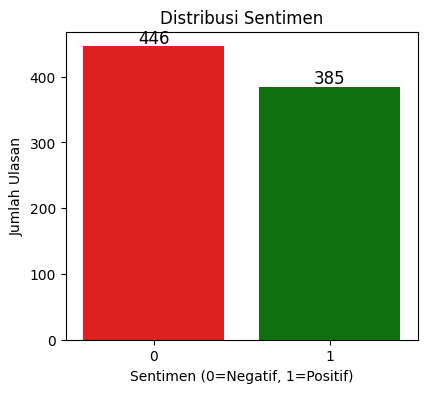

In [8]:
# Visualisasi
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.countplot(x='label', data=df, hue='label', palette={0:'red', 1:'green'}, legend=False)
plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen (0=Negatif, 1=Positif)')
plt.ylabel('Jumlah Ulasan')

# Loop untuk menambahkan angka di atas bar
for i in range(2):
    # Ambil count berdasarkan index yang sudah disortir (0 lalu 1)
    count = df['label'].value_counts().sort_index()[i]
    plt.text(i, count + 5, str(count), ha='center', fontsize=12)

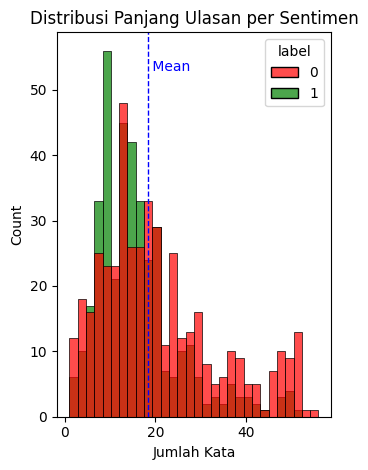

In [9]:
plt.subplot(1,2,2)
# Ubah key palette jadi string juga agar konsisten
sns.histplot(data=df, x='text_length', hue='label', bins=30, alpha=0.7, palette={0:'red', 1:'green'})
plt.title('Distribusi Panjang Ulasan per Sentimen')
plt.xlabel('Jumlah Kata')

plt.axvline(df['text_length'].mean(), color='blue', linestyle='dashed', linewidth=1)
plt.text(df['text_length'].mean(), plt.ylim()[1]*0.9, ' Mean', color='blue')

plt.tight_layout()
plt.show()

In [10]:
# Split dataset
train_df, temp_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label'], shuffle=True
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'], shuffle=True
)

# Hasil split
tabel_split = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'Jumlah Data': [len(train_df), len(val_df), len(test_df)]
})
display(tabel_split)

,Dataset,Jumlah Data
0,Train,664
1,Validation,83
2,Test,84


Tokenization

In [11]:
model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['reviews'], truncation=True, max_length=128)

train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
val_dataset   = Dataset.from_pandas(val_df).map(tokenize_function, batched=True)
test_dataset  = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(['reviews', 'text_length'])
val_dataset   = val_dataset.remove_columns(['reviews', 'text_length'])
test_dataset  = test_dataset.remove_columns(['reviews', 'text_length'])

train_dataset.set_format('torch')
val_dataset.set_format('torch')
test_dataset.set_format('torch')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/664 [00:00<?, ? examples/s]

Map:   0%|          | 0/83 [00:00<?, ? examples/s]

Map:   0%|          | 0/84 [00:00<?, ? examples/s]

Model & Training

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    acc = accuracy_score(p.label_ids, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='binary')
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_steps=100,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    logging_dir='./logs',
    report_to=[]
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("\nStarting training...")
trainer.train()

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.421111,0.843373,0.755102,0.973684,0.850575
2,No log,0.203328,0.939759,0.945946,0.921053,0.933333
3,No log,0.255371,0.927711,0.921053,0.921053,0.921053


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=126, training_loss=0.3131584894089472, metrics={'train_runtime': 1392.7586, 'train_samples_per_second': 1.43, 'train_steps_per_second': 0.09, 'total_flos': 56651099107200.0, 'train_loss': 0.3131584894089472, 'epoch': 3.0})

Visualization & Evaluation

In [13]:
print("\nEvaluation on Test Set:")

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Metrics Table
acc = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

df_metrics = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Value": [acc, precision, recall, f1]
})
display(df_metrics)


Evaluation on Test Set:


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


,Metric,Value
0,Accuracy,0.964286
1,Precision,1.000000
2,Recall,0.923077
3,F1-Score,0.960000


In [14]:
# Classification Report
report = classification_report(labels, preds, target_names=['Negatif', 'Positif'], output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

,precision,recall,f1-score,support
Negatif,0.937500,1.000000,0.967742,45.000000
Positif,1.000000,0.923077,0.960000,39.000000
accuracy,0.964286,0.964286,0.964286,0.964286
macro avg,0.968750,0.961538,0.963871,84.000000
weighted avg,0.966518,0.964286,0.964147,84.000000


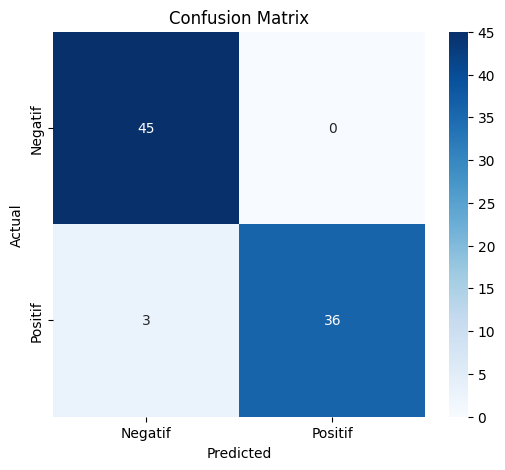

In [15]:
# Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif', 'Positif'],
            yticklabels=['Negatif', 'Positif'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

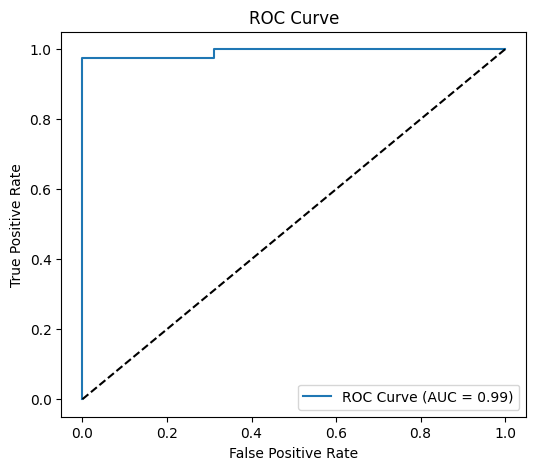

In [18]:
# ROC Curve
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()
fpr, tpr, _ = roc_curve(labels, probs[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Save Model & Download

In [19]:
save_path = '/content/drive/MyDrive/AMIKOM/SEMESTER 5/KECERDASAN BUATAN LANJUT/PDK_AI_UAS/model_sentimen'
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

zip_path = '/content/model_sentimen.zip'
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as z:
    for root, _, files_in in os.walk(save_path):
        for file in files_in:
            z.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), save_path))

files.download(zip_path)
print("\nModel berhasil disimpan dan di-zip! File: model_sentimen.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Model berhasil disimpan dan di-zip! File: model_sentimen.zip


Gradio UI

In [21]:
history = []

def predict_sentiment(text):
    if not text or not text.strip():
        return "Mohon masukkan ulasan terlebih dahulu!", "", pd.DataFrame(columns=["Ulasan", "Sentimen", "Confidence", "Emoji"])

    # Clean input text sesuai preprocessing training
    text_clean = clean_text(text)

    # Prediksi
    inputs = tokenizer(text_clean, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    pred_idx = torch.argmax(outputs.logits).item()

    label_str = "Positif 😊" if pred_idx == 1 else "Negatif 😞"
    sentiment_only = "Positif" if pred_idx == 1 else "Negatif"
    confidence = probs[0][pred_idx].item()

    result = f"{label_str}\nConfidence: {confidence:.2%}"

    # Update history
    history.append({
        "Ulasan": text, # Simpan teks asli
        "Sentimen": sentiment_only,
        "Confidence": f"{confidence:.2%}",
        "Emoji": "😊" if pred_idx == 1 else "😞"
    })

    # Limit history
    history_df = pd.DataFrame(history[-20:])

    return result, "", history_df

with gr.Blocks(title="Analisis Sentimen Ulasan Produk") as iface:
    gr.Markdown("# 🔍 Analisis Sentimen Ulasan Produk E-Commerce")
    gr.Markdown("Model menggunakan **IndoBERT** yang telah di-fine-tune pada dataset ulasan produk dalam Bahasa Indonesia.")

    with gr.Row():
        with gr.Column(scale=3):
            input_text = gr.Textbox(
                lines=4,
                placeholder="Ketik ulasan produk di sini...",
                label="Masukkan Ulasan",
                show_label=True
            )
            submit_btn = gr.Button("🔮 Prediksi Sentimen", variant="primary", size="lg")

        with gr.Column(scale=2):
            output_label = gr.Textbox(
                label="Hasil Prediksi",
                lines=4,
                interactive=False
            )

    gr.Markdown("### 📋 Riwayat Prediksi (20 terakhir)")
    history_table = gr.Dataframe(
        headers=["Ulasan", "Sentimen", "Confidence", "Emoji"],
        datatype=["str", "str", "str", "str"],
        row_count=10,
        max_height=500,
        wrap=True,
        column_widths=["50%", "15%", "15%", "10%"]
    )

    submit_btn.click(
        fn=predict_sentiment,
        inputs=input_text,
        outputs=[output_label, input_text, history_table]
    )

    input_text.submit(
        fn=predict_sentiment,
        inputs=input_text,
        outputs=[output_label, input_text, history_table]
    )

print("\nLaunching demo interaktif dengan history table...")
iface.launch(share=True)


Launching demo interaktif dengan history table...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c115990e7f64c0cf51.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
